In [1]:
import sys
import os

# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
# EDA utilities
from src.eda_utils import get_headline_stats, count_publishers
from src.text_analysis import analyze_sentiment

# Text utilities and plotting
from scripts.text_utils import get_word_frequency
from scripts.plot import plot_bar, plot_line

import pandas as pd


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/shadowlast/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
from scripts.utils import load_csv

data_path = "Data/modularization-demo/data/raw_analyst_ratings.csv"
df = load_csv(data_path)

# Clean column names
from scripts.utils import clean_column_names
df = clean_column_names(df)
df.head()


,unnamed:_0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
headline_stats = get_headline_stats(df)
print("Headline Stats:\n", headline_stats)


Headline Stats:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


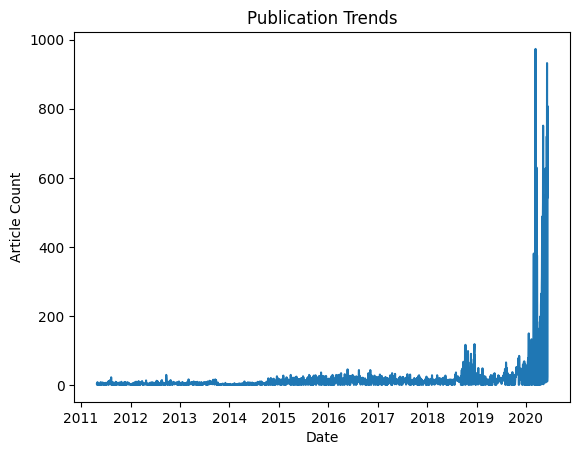

In [5]:
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
daily_counts = df["date"].dt.date.value_counts().sort_index()
plot_line(daily_counts, title="Publication Trends", xlabel="Date", ylabel="Article Count")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/shadowlast/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!

nalyzing Sentiment: 100%|█████████| 1407328/1407328 [00:24<00:00, 57924.42it/s]

                                            headline sentiment
0            Stocks That Hit 52-Week Highs On Friday   neutral
1         Stocks That Hit 52-Week Highs On Wednesday   neutral
2                      71 Biggest Movers From Friday   neutral
3       46 Stocks Moving In Friday's Mid-Day Session   neutral
4  B of A Securities Maintains Neutral on Agilent...  positive


/tmp/ipykernel_3601/434261841.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel')


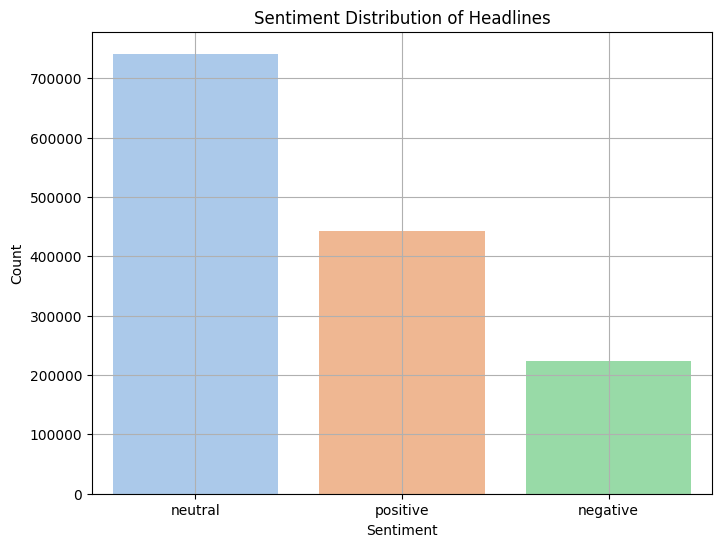

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Download VADER lexicon (only needed once)
download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis in parallel
def parallel_sentiment_analysis(df, column='headline', n_jobs=-1):
    """
    Apply VADER sentiment analysis to a DataFrame column in parallel.
    Classify sentiment as Positive, Neutral, or Negative based on compound score.
    """
    def analyze_sentiment(text):
        """
        Analyze sentiment of a single text using VADER.
        Returns: 'positive', 'neutral', or 'negative'.
        """
        sentiment_score = sia.polarity_scores(text)
        if sentiment_score['compound'] >= 0.05:
            return 'positive'
        elif sentiment_score['compound'] <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    
    # Use joblib's Parallel and delayed to process the text in parallel
    sentiments = Parallel(n_jobs=n_jobs)(
        delayed(analyze_sentiment)(text) for text in tqdm(df[column], desc="Analyzing Sentiment")
    )
    # Assign the results to a new column in the DataFrame
    df['sentiment'] = sentiments
    return df

# Apply sentiment analysis
df = parallel_sentiment_analysis(df, column='headline')

# Output the first few rows for verification
print(df[['headline', 'sentiment']].head())

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='pastel')
plt.title('Sentiment Distribution of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid()
plt.show()

Top Keywords:
 [('to', 402906), ('of', 269814), ('on', 245082), ('for', 239535), ('in', 220612), ('the', 212863), ('m', 186060), ('vs', 162147), ('stocks', 161868), ('q', 157878)]


/tmp/ipykernel_3601/770860469.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencies, y=words, palette="coolwarm")


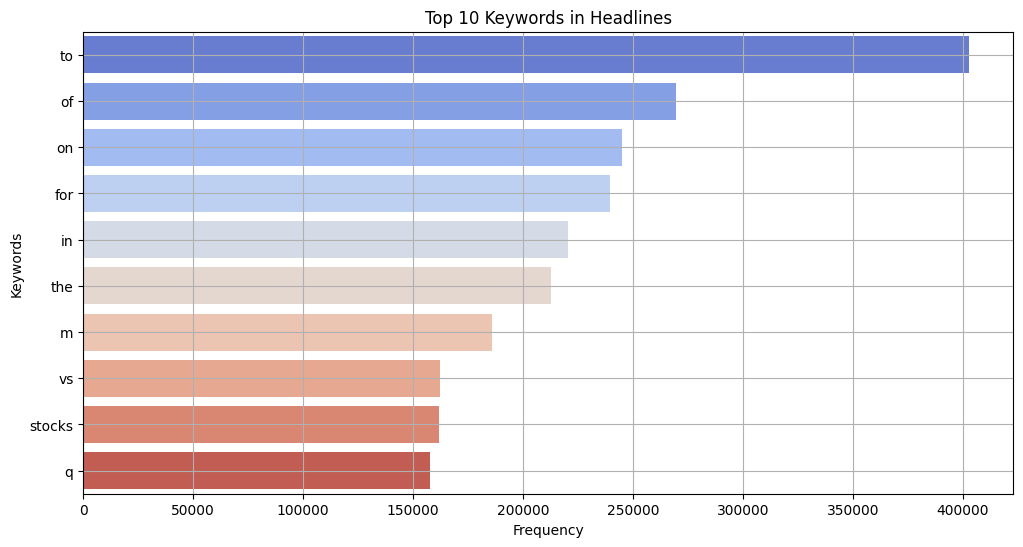

In [7]:
from collections import Counter
import pandas as pd
import re

def get_word_frequency(headlines, top_n=10):
    """
    Calculate the frequency of words in a list of headlines.

    Args:
        headlines (pd.Series): A pandas Series containing text data (headlines).
        top_n (int): Number of top words to return.

    Returns:
        List[Tuple[str, int]]: List of tuples with the top_n words and their frequencies.
    """
    # Combine all headlines into one string and clean the text
    combined_text = " ".join(headlines)
    cleaned_text = re.sub(r"[^a-zA-Z\s]", "", combined_text.lower())  # Remove non-alphabetic characters

    # Tokenize the text into words
    words = cleaned_text.split()

    # Count word frequencies
    word_counts = Counter(words)

    # Return the top_n most common words
    return word_counts.most_common(top_n)

# Example usage with your DataFrame
keywords = get_word_frequency(df["headline"], top_n=10)
print("Top Keywords:\n", keywords)

# Plot the top keywords
words, frequencies = zip(*keywords)  # Unpack words and frequencies

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=frequencies, y=words, palette="coolwarm")
plt.title("Top 10 Keywords in Headlines")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.grid()
plt.show()


In [8]:
# Descriptive Statistics: Text Length and Publisher Count
import pandas as pd

# Assuming 'df' is your DataFrame containing the headlines and other relevant data
# 1. Textual Length of Headlines
df['headline_length'] = df['headline'].apply(len)

# 2. Article Count Per Publisher (assuming 'publisher' column exists)
publisher_counts = df['publisher'].value_counts()

# 3. Date Trends (using the correct column name 'date')
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime if not already
date_counts = df['date'].dt.date.value_counts().sort_index()

# Show basic statistics
print(f"Textual Length Statistics:\n{df['headline_length'].describe()}")
print(f"\nArticle Counts by Publisher:\n{publisher_counts}")
print(f"Date Counts:\n{date_counts.head()}")

Textual Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

Article Counts by Publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64
Date Counts:
date
2011-04-28    3
2011-04-29    2
2011-04-30    1
2011-05-01    1
2011-05-02    9
Name: count, dtype: int64


In [9]:
# Topic Modeling using LDA (Latent Dirichlet Allocation)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert headlines into a term-document matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['headline'])

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust number of topics as needed
lda.fit(X)

# Display the topics
n_top_words = 10
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #0:
pt buy target maintains raises price 00 downgrades announces upgrades
Topic #1:
vs est eps reports sales q4 q1 estimate q2 q3
Topic #2:
earnings stock scheduled share says announces shares reports ahead offering
Topic #3:
shares trading higher companies lower oil earnings analyst market following
Topic #4:
stocks market benzinga week mid 52 day session moving update


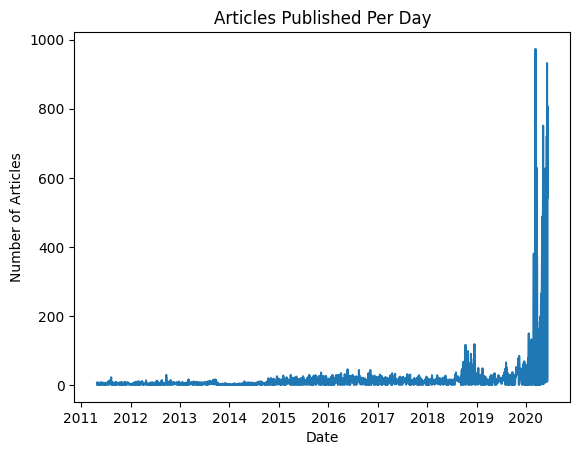

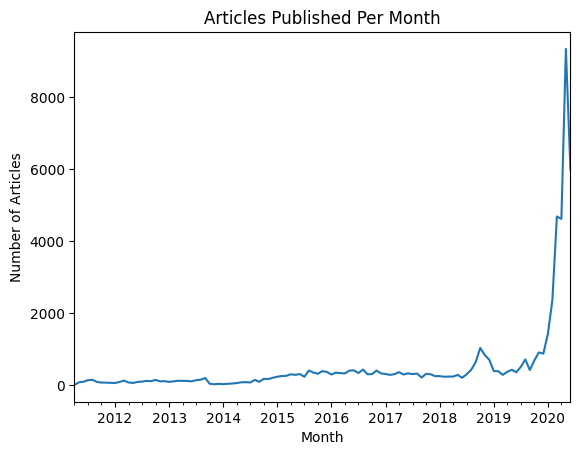

In [10]:
import matplotlib.pyplot as plt

# Plot the number of articles per day
daily_article_counts = df['date'].dt.date.value_counts().sort_index()
daily_article_counts.plot(kind='line', title='Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Optionally, you could analyze monthly trends as well
monthly_article_counts = df['date'].dt.to_period('M').value_counts().sort_index()
monthly_article_counts.plot(kind='line', title='Articles Published Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()


In [11]:
# Show the top publishers by article count
top_publishers = df['publisher'].value_counts().head(10)

# If 'publisher' contains email addresses, extract the domain
if df['publisher'].str.contains('@').any():
    df['publisher_domain'] = df['publisher'].apply(lambda x: x.split('@')[1] if '@' in x else 'Unknown')
    publisher_domain_counts = df['publisher_domain'].value_counts()

    # Show the top domains
    print(f"Top Publisher Domains:\n{publisher_domain_counts.head(10)}")

# Show top publishers by article count
print(f"Top Publishers:\n{top_publishers}")


Top Publisher Domains:
publisher_domain
Unknown                   1399240
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: count, dtype: int64
Top Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64
